PoCRA assignment by Vipin Singh - 19D070069

# Imports

In [1]:
import pandas as pd
from google.colab import files
import matplotlib.pyplot as plt
import numpy as np
import statistics


## Dataset

In [2]:
# Importing Dataset
rainfall = pd.read_csv('rainfall.csv')
print(rainfall.head())

         date  rain_mm
0  2022-06-01      0.0
1  2022-06-02      0.0
2  2022-06-03      0.0
3  2022-06-04      0.0
4  2022-06-05      0.0


# Soil Model Defination

In [3]:
class Soil:
    def __init__(self, Soil_Type, max_uptake = 4):
      ''' Take input as Soil type and we can also change Maximum Uptake per day if requreid'''
      self.Soil_Type = Soil_Type
     
      if self.Soil_Type  == "Deep":
        # Deep Soil Type Parameters
        self.ground_water_fraction = 0.2
        self.C = 100

      elif self.Soil_Type  == "Shallow":
        # Shallow Soil Type Parameters
        self.ground_water_fraction = 0.4
        self.C = 42
      else:
        # Invalid Soil Type
        print("INVALID Soil Type")

      # Setting other parameters of Soil
      self.runoff = 0
      self.infiltration = 0
      self.ground_water = 0
      self.uptake = 0
      self.csm = 0
      # Setting Crop Parametrs
      self.max_uptake = max_uptake

    
    def runoff_factor(self,rain_amount):
      '''Calculate the run off factor alpha depending on the amount of rain'''
      if rain_amount < 25:
        return 0.2
      elif rain_amount < 50:
        return 0.3
      elif rain_amount < 75:
        return 0.4
      elif rain_amount < 100:
        return 0.5
      else:
        return 0.7

    def rainfall(self,rain_amount):
      '''Calculate Runoof and Infiltration water amount'''
      if rain_amount == float(0):
        # No rain Condition
        self.runoff = 0
        self.infiltration = 0
      else:
        # Rain
        alpha = self.runoff_factor(rain_amount) # Calculate Run off Factor
        self.runoff = alpha * rain_amount # Find Runoff
        self.infiltration  = rain_amount - self.runoff
        if self.infiltration + self.csm> self.C:
          # Infiltration more than C, excess goes in runoff as well. NOTE: If required to store excess water, modify here
          self.infiltration = self.C - self.csm
          self.runoff = rain_amount - self.C + self.csm
        self.csm += self.infiltration 
      return [self.runoff,self.infiltration]
    
    def uptake_calc(self):
      '''Uptake by crop, take maximum if available else take the remaining'''
      if self.csm >= self.max_uptake:
        self.csm -= self.max_uptake
        self.uptake = self.max_uptake
      else:
        self.uptake = self.csm
        self.csm = 0
      return self.uptake

    def ground_water_calc(self):
      # At the End calculate the groundwater, Assuming it is gamma times the current soil moisture. Before Groundwater Percolation total water is sm(n) (1+gamma)
      self.ground_water = self.csm*self.ground_water_fraction/(1+self.ground_water_fraction)
      self.csm /= (1+self.ground_water_fraction)
      
      if(self.csm > self.C):
        self.ground_water += self.csm - self.C
        self.csm = self.C
      return [self.ground_water ,self.csm]
    
    def new_day(self,rain_amount):
      # Calculate the parameter at the end of the day, need rain amount as input
      self.rain_water = float(rain_amount)
      self.rainfall(self.rain_water)
      self.uptake_calc()
      self.ground_water_calc()
      return [self.csm,self.rain_water,self.runoff,self.infiltration,self.uptake,self.ground_water]



# Validation

In [4]:
def validation(file_name,error_allowed = 0.0000000001):
  '''Return True if Global as well as Local Conition are Satisfied'''
  soil_distrubtion = pd.read_csv(file_name)
  valid = True
  # Variable Setting
  psm = 0 # Previous day soil moisture
  total_rain = 0 # Total Rain upto Day n
  total_runoff = 0 # Total Run Off upto Day n
  total_uptake = 0 # Total Uptake Upto Day n
  total_gw = 0 # Total GW upto Day n

  # Local Check
  for ind in soil_distrubtion.index:

    local_check = soil_distrubtion['Rain (in mm)'][ind] - (soil_distrubtion['SM'][ind] - psm + soil_distrubtion['Run Off'][ind] + soil_distrubtion['Uptake'][ind] + soil_distrubtion['Ground Water'][ind])
    #Parameters for Global Check
    total_rain +=  soil_distrubtion['Rain (in mm)'][ind]
    total_runoff += soil_distrubtion['Run Off'][ind]
    total_uptake += soil_distrubtion['Uptake'][ind]
    total_gw += soil_distrubtion['Ground Water'][ind]

    # print(local_check)
    if abs(local_check) <= error_allowed:
      psm = soil_distrubtion['SM'][ind]
      continue
    else:
      print("Local Balance Not Satisfied on " + soil_distrubtion['Date'][ind] + " Extra Rain Fall = " +str(temp))
      valid = False
      break
  
  if not valid:
    return False
  print("Local Balance Satisfied for all Day")
    
  # Global Check

  #psm has the last day SM(n) value

  global_check = total_rain - (psm +total_runoff + total_uptake+total_gw)
  if abs(global_check) <= error_allowed:
    print("Global Balance Satisfied")
  else:
    print("Global Balance NOT Satisfied")
    valid = False
  return valid

## Deep Soil Type

In [5]:
# Define Soil Model to type Deep
deep = Soil("Deep")

In [6]:
# Creating Data Frame To Store the Output
deep_output = pd.DataFrame(columns=['Date','SM','Rain (in mm)','Run Off','Infiltration','Uptake','Ground Water'])

In [7]:
# Generating output day by day
for ind in rainfall.index:
  temp = deep.new_day(rainfall['rain_mm'][ind]) # Temp = [sm(n),rain(n),total_run_off(n),infiltration(n),uptake(n),gw(n)]
  deep_output.loc[len(deep_output.index)] = [rainfall['date'][ind]]+temp


In [8]:
display(deep_output)

,Date,SM,Rain (in mm),Run Off,Infiltration,Uptake,Ground Water
0,2022-06-01,0.0,0.0,0.0,0.0,0.0,0.0
1,2022-06-02,0.0,0.0,0.0,0.0,0.0,0.0
2,2022-06-03,0.0,0.0,0.0,0.0,0.0,0.0
3,2022-06-04,0.0,0.0,0.0,0.0,0.0,0.0
4,2022-06-05,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
160,2022-11-08,0.0,0.0,0.0,0.0,0.0,0.0
161,2022-11-09,0.0,0.0,0.0,0.0,0.0,0.0
162,2022-11-10,0.0,0.0,0.0,0.0,0.0,0.0
163,2022-11-11,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
# Converting DataFrame to CSV
deep_output.to_csv('deep.csv')
# Downloading CSV file to Local PC
files.download('deep.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [10]:
validation("deep.csv")

Local Balance Satisfied for all Day
Global Balance Satisfied


True

## Shallow Soil Typpe

In [11]:
shallow = Soil("Shallow")

In [12]:
shallow_output = pd.DataFrame(columns=['Date','SM','Rain (in mm)','Run Off','Infiltration','Uptake','Ground Water'])

In [13]:
for ind in rainfall.index:
  temp = shallow.new_day(rainfall['rain_mm'][ind]) # Temp = [sm(n),rain(n),total_run_off(n),infiltration(n),uptake(n),gw(n)]
  shallow_output.loc[len(shallow_output.index)] = [rainfall['date'][ind]]+temp

In [14]:
# Converting DataFrame to CSV
shallow_output.to_csv('shallow.csv')
# Downloading CSV file to Local PC
files.download('shallow.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [15]:
validation("shallow.csv")

Local Balance Satisfied for all Day
Global Balance Satisfied


True

# Results

In [16]:
def important_result(sd):
  # sd = pd.read_csv(file_name)
  total_uptake = 0
  total_rain = 0
  total_runoff = 0
  max_uptake_days = 0
  zero_uptake_days = 0
  max_uptake = 4
  total_gw = 0
  no_uptake_hist = {}

  # Show the graph
  plt.show()
  no_uptake_days = 0
  for ind in sd.index:
    total_uptake += sd['Uptake'][ind]
    total_rain += sd['Rain (in mm)'][ind]
    total_runoff += sd['Run Off'][ind]
    total_gw += sd["Ground Water"][ind]
    if sd['Uptake'][ind] == 0:
      zero_uptake_days+= 1
      no_uptake_days+=1
    elif sd['Uptake'][ind] == max_uptake:
      if(no_uptake_days!=0):
        if no_uptake_days in no_uptake_hist:
          no_uptake_hist[no_uptake_days] +=1
        else:
          no_uptake_hist[no_uptake_days] = 1
      no_uptake_days = 0
      max_uptake_days += 1
    else:
      if(no_uptake_days!=0):
        if no_uptake_days in no_uptake_hist:
          no_uptake_hist[no_uptake_days] +=1
        else:
          no_uptake_hist[no_uptake_days] = 1
        no_uptake_days = 0

  result = {"no_uptake_hist":no_uptake_hist,"total_day":len(sd.index),"total_gw":total_gw,"total_uptake" : total_uptake, "total_rain": total_rain, "total_runoff": total_runoff,"zero_uptake_days" :zero_uptake_days,"max_uptake_days":max_uptake_days}
  return result
  

In [17]:
def plot_result(result):

  # Dictionary of values
  days_dict = result['no_uptake_hist']

  # Create lists for keys and values
  keys_list = list(days_dict.keys())
  values_list = list(days_dict.values())

  # Create a bar graph
  plt.bar(keys_list, values_list)

  # Add labels and title
  plt.xlabel('Number of Continuos Days of no Water to Plant')
  plt.ylabel('Frequency')
  plt.title('No Uptake Frequency')

  # Show the graph
  plt.show()



  # Net Water Distribution
  print("Net Water Distribution")
  water_dist = np.array([result["total_uptake"], result["total_runoff"], result["total_gw"]])
  labels = ["Uptake", "Run Off", "Ground Water"]
  wp = {'linewidth': 1, 'edgecolor': 'black'}

  plt.pie(water_dist, labels=labels, autopct='%1.1f%%',wedgeprops = wp)

  # Add title
  plt.title('Net Water Distrubution')

  # Show chart
  plt.show()

  print("Uptake Distribution")
  uptake_dist = np.array([result["max_uptake_days"], result["zero_uptake_days"], result["total_day"] - result["max_uptake_days"] - result["zero_uptake_days"]])
  labels = ["Demand Fullfilled", "No Water to Crops", "Partial Demand fullfilled"]
  plt.pie(uptake_dist, labels=labels, autopct='%1.1f%%',wedgeprops = wp)

  # Add title
  plt.title('Uptake Distribution')

  # Show chart
  plt.show()



## Shallow

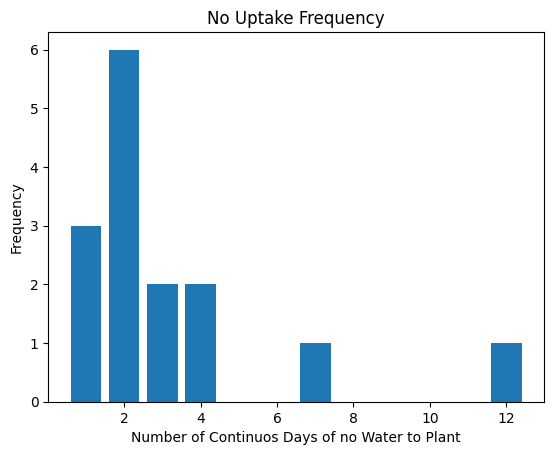

Net Water Distribution


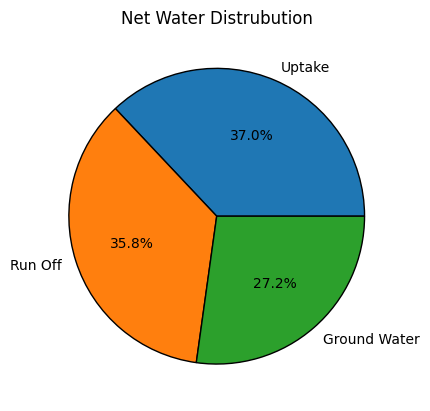

Uptake Distribution


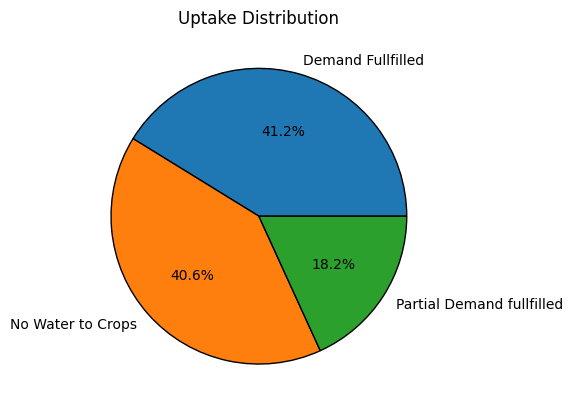

In [18]:
shallow_df = pd.read_csv("shallow.csv")
shallow_data = important_result(shallow_df)
plot_result(shallow_data)

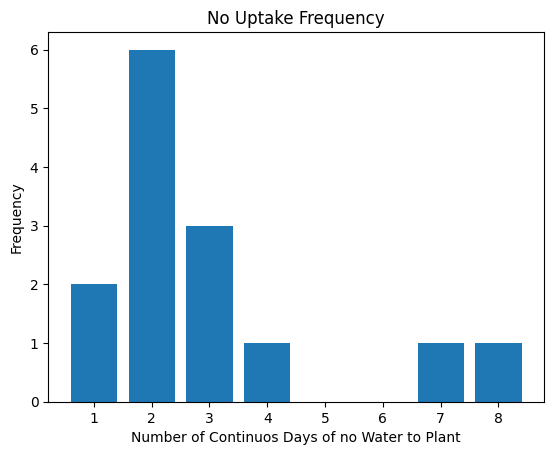

Net Water Distribution


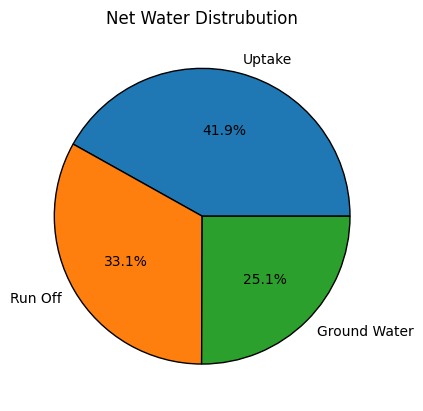

Uptake Distribution


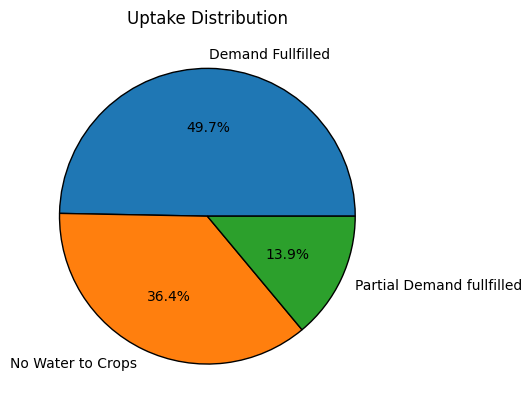

In [19]:
deep_df = pd.read_csv("deep.csv")
deep_data = important_result(deep_df)
plot_result(deep_data)

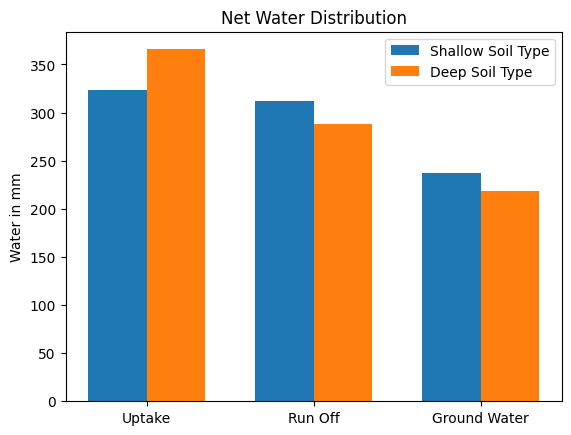

In [20]:
# Net Water Distribution 
# Define data
labels = ["Uptake", "Run Off", "Ground Water"]
values1 = [shallow_data["total_uptake"], shallow_data["total_runoff"],shallow_data["total_gw"]]
values2 = [deep_data["total_uptake"], deep_data["total_runoff"],deep_data["total_gw"]]

# Set the bar width
width = 0.35

# Define the x axis
x = np.arange(len(labels))

# Create the plot
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, values1, width, label='Shallow Soil Type')
rects2 = ax.bar(x + width/2, values2, width, label='Deep Soil Type')

# Add some text for labels, title, and axes ticks
ax.set_ylabel('Water in mm')
ax.set_title('Net Water Distribution')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Display the plot
plt.show()


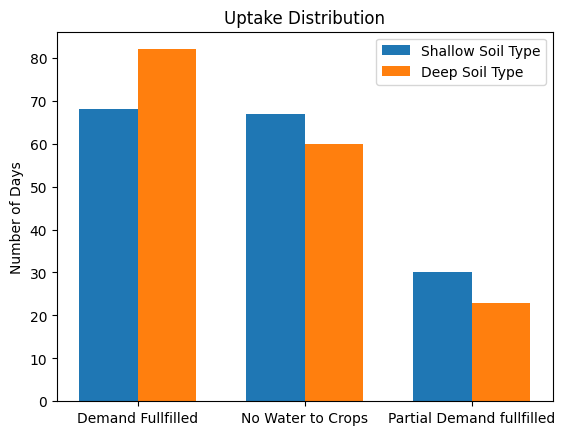

In [21]:
# Uptake Distribution
# Define data
labels = ["Demand Fullfilled", "No Water to Crops", "Partial Demand fullfilled"]
values1 = [shallow_data["max_uptake_days"], shallow_data["zero_uptake_days"], shallow_data["total_day"] - shallow_data["max_uptake_days"] - shallow_data["zero_uptake_days"]]
values2 = [deep_data["max_uptake_days"], deep_data["zero_uptake_days"], deep_data["total_day"] - deep_data["max_uptake_days"] - deep_data["zero_uptake_days"]]

# Set the bar width
width = 0.35

# Define the x axis
x = np.arange(len(labels))

# Create the plot
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, values1, width, label='Shallow Soil Type')
rects2 = ax.bar(x + width/2, values2, width, label='Deep Soil Type')

# Add some text for labels, title, and axes ticks
ax.set_ylabel('Number of Days')
ax.set_title('Uptake Distribution')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Display the plot
plt.show()

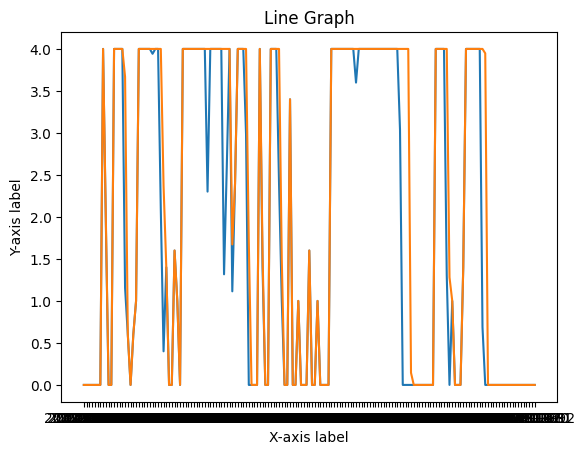

In [22]:
plt.plot(shallow_df['Date'],shallow_df['Uptake'],label = "Shallow")
plt.plot(deep_df['Date'],deep_df['Uptake'], label = "Deep")
plt.xlabel('X-axis label')
plt.ylabel('Y-axis label')
plt.title('Line Graph')

# Show the graph
plt.show()